In [1]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize, downscale_local_mean
import math
import os
import numpy as np

import seaborn as sns
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import pingouin as pg
import scikit_posthocs as sp

import sys
sys.path.append("../../")
from DataSorting import *
import numpy as np
import matplotlib.pyplot as plt

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


# Temporal Phase Standard Deviation Maps

In [2]:
# helper function for image edge outline 
from PIL import Image, ImageFilter
def get_edge(img):
    #define the vertical filter
    vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

    #define the horizontal filter
    horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

    #get the dimensions of the image
    n,m = img.shape

    #initialize the edges image
    edges_img = img.copy()

    #loop over all pixels in the image
    for row in range(3, n-2):
        for col in range(3, m-2):

            #create little local 3x3 box
            local_pixels = img[row-1:row+2, col-1:col+2]

            #apply the vertical filter
            vertical_transformed_pixels = vertical_filter*local_pixels
            #remap the vertical score
            vertical_score = vertical_transformed_pixels.sum()/4

            #apply the horizontal filter
            horizontal_transformed_pixels = horizontal_filter*local_pixels
            #remap the horizontal score
            horizontal_score = horizontal_transformed_pixels.sum()/4

            #combine the horizontal and vertical scores into a total edge score
            edge_score = (vertical_score**2 + horizontal_score**2)**.5

            #insert this edge score into the edges image
            edges_img[row, col] = edge_score*2

    #remap the values in the 0-1 range in case they went out of bounds
    edges_img = edges_img/edges_img.max()
    edges_img[edges_img ==0] = 'nan'
    edges_img[edges_img >0] = 1
    return edges_img

In [3]:
# Pick volunteer, vv=0 0 was used to make the figure in the manuscript, this corresponds to volunteer 1 
vv = 0

In [4]:
volunteers=[1,2,3,4,5,7,8,9,10,11]


# For each volunteer 
M0_mag = np.zeros((128,128,6,4,5,8))
M1_mag = np.zeros((128,128,6,4,5,8))
M2_mag = np.zeros((128,128,6,4,5,8))

M0_phs = np.zeros((128,128,6,4,5,8))
M1_phs = np.zeros((128,128,6,4,5,8))
M2_phs = np.zeros((128,128,6,4,5,8))


volunteer = str(volunteers[vv])
print(volunteer, end = ' ')
inpath = '/Users/arielhannum/Documents/Stanford/CMR-Setsompop/Projects/Phase/Data/Brain/V00' + volunteer + '/3_DWI/'
name = inpath.split('/')
namejoin = '/'.join(name[:-1])

num = 0
for num in range(3):
    nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
    bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
    bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
    mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
    

    nii_files.sort()
    bval_files.sort()
    bvec_files.sort()
    mask_files.sort()
    
    data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
    bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
    bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
    mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
    
    mask = mask.astype('float')
    mask[mask==0] = np.nan
    
    
    data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
    
    ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                        data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                        data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
        
    
    mag = abs(ims)
    phs = np.angle(ims)
    mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
    mask_rep[mask_rep ==0] = np.nan
    
    if num == 0:
        M0_mag[:,:,:,:,:,:] = mag #* mask_rep
        M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
        M0_mask = mask_rep #*mask_rep
        
    if num == 1:
        M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
        M1_phs[:,:,:,:,:,:] = phs #*mask_rep
        M1_mask = mask_rep #*mask_rep
        
    if num == 2:
        M2_mag[:,:,:,:,:,:] = mag #* mask_rep
        M2_phs[:,:,:,:,:,:] = phs #*mask_rep
        M2_mask = mask_rep #*mask_rep

# Divide by average background phase 
M0_adj = (np.exp(1j*M0_phs))/np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M1_adj = (np.exp(1j*M1_phs))/np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
M2_adj = (np.exp(1j*M2_phs))/np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:] 

M0_diff = np.angle(M0_adj / np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M1_diff = np.angle(M1_adj / np.tile(np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))
M2_diff = np.angle(M2_adj / np.tile(np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1)))

M0_std = np.sqrt(np.sum(M0_diff**2,axis = -2)/5)
M1_std = np.sqrt(np.sum(M1_diff**2,axis = -2)/5)
M2_std = np.sqrt(np.sum(M2_diff**2,axis = -2)/5)

1 

/Users/arielhannum/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
diffusion = -1 # diffusion direction [0, X [1], Y[2], Z[3]]
sl = 3 #slice [brainstem [0], upper cortex[5]]
rep = 1

## Temporal Phase Standard Deviation Maps

TD 0 Volunteer 0 slice 3
Median Temporal Phase SD M0 1.15 Median Temporal Phase SD M1 0.7 Median Temporal Phase SD M2 0.29 

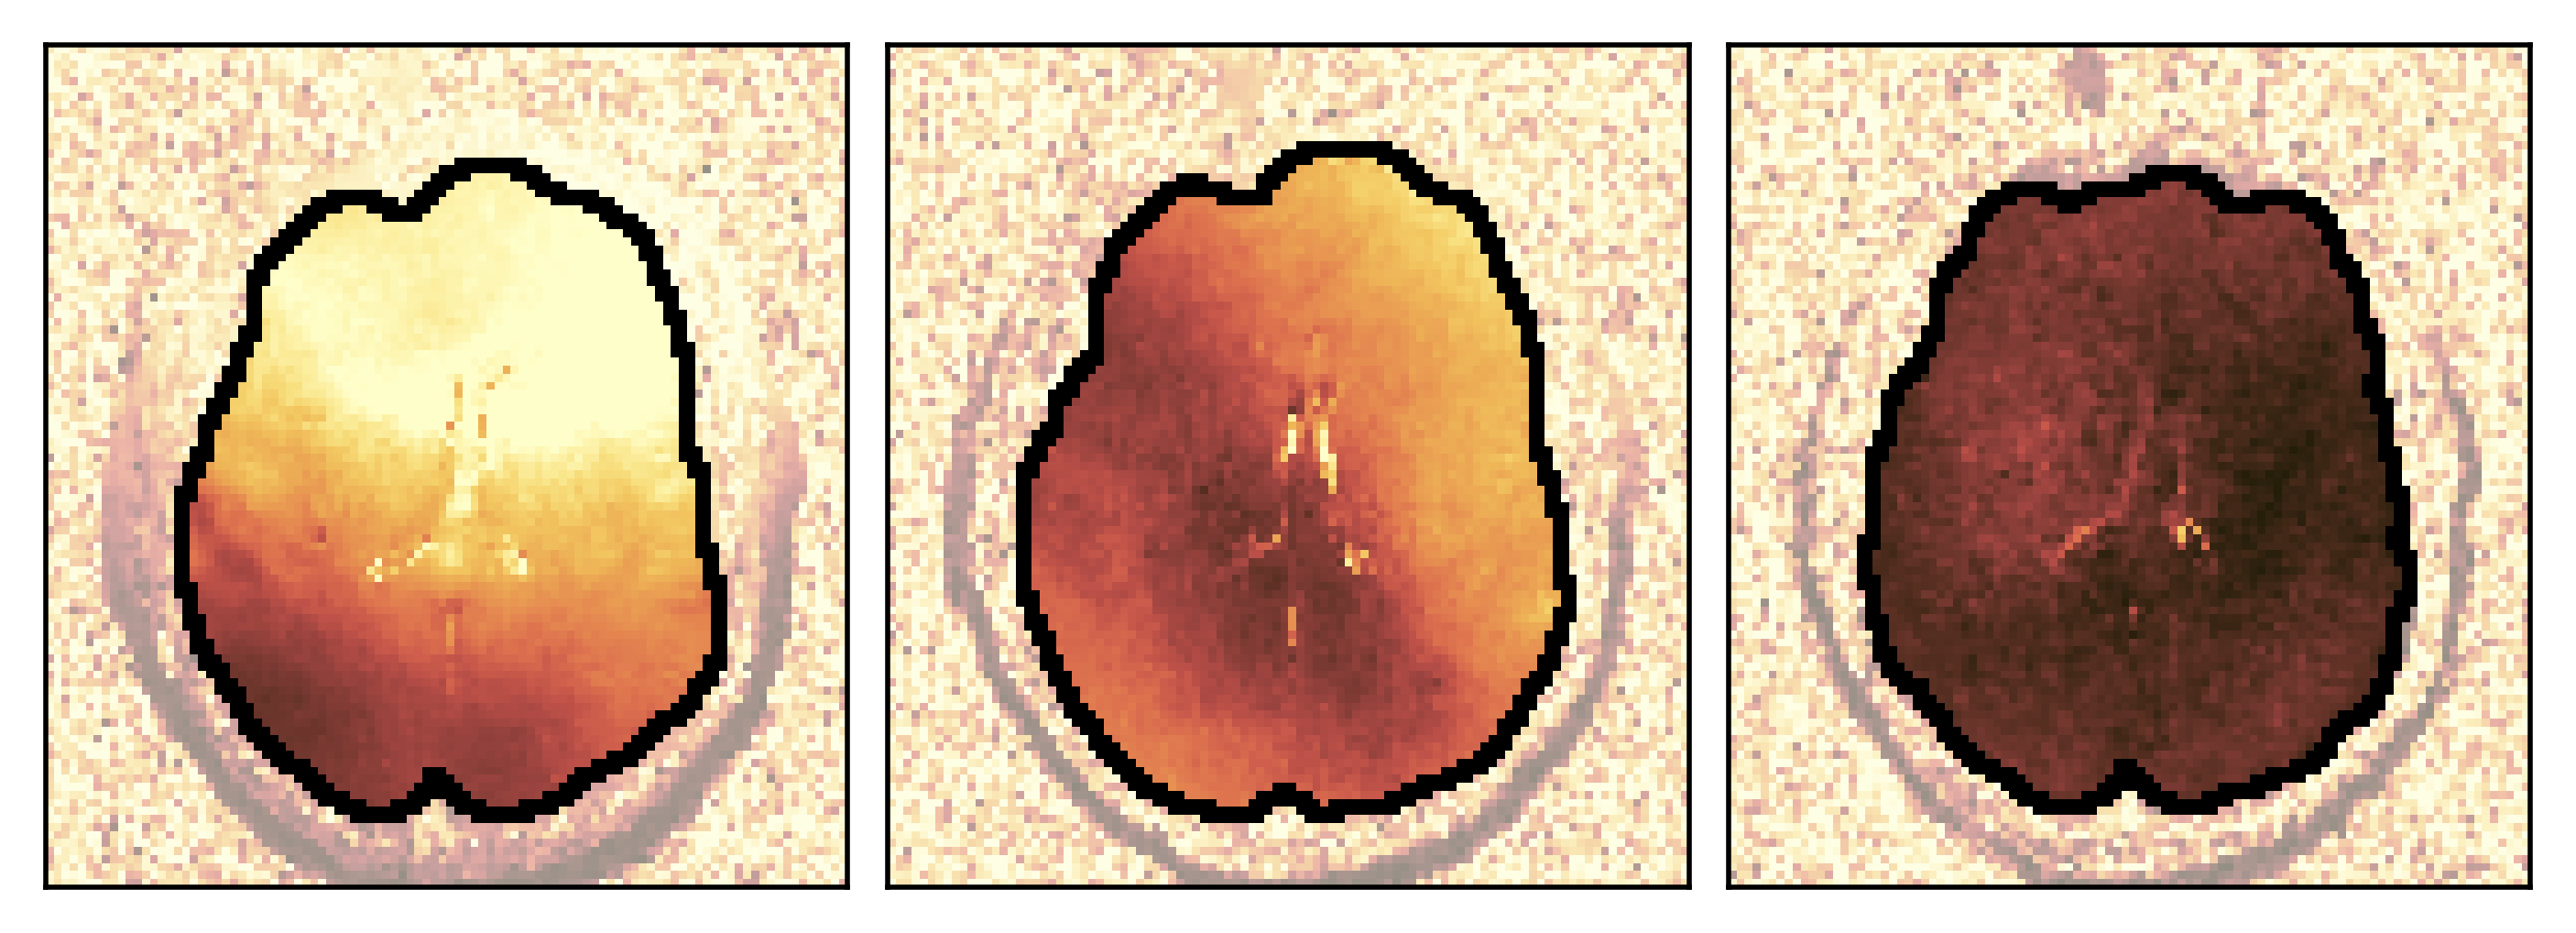

TD 1 Volunteer 0 slice 3
Median Temporal Phase SD M0 1.17 Median Temporal Phase SD M1 0.27 Median Temporal Phase SD M2 0.39 

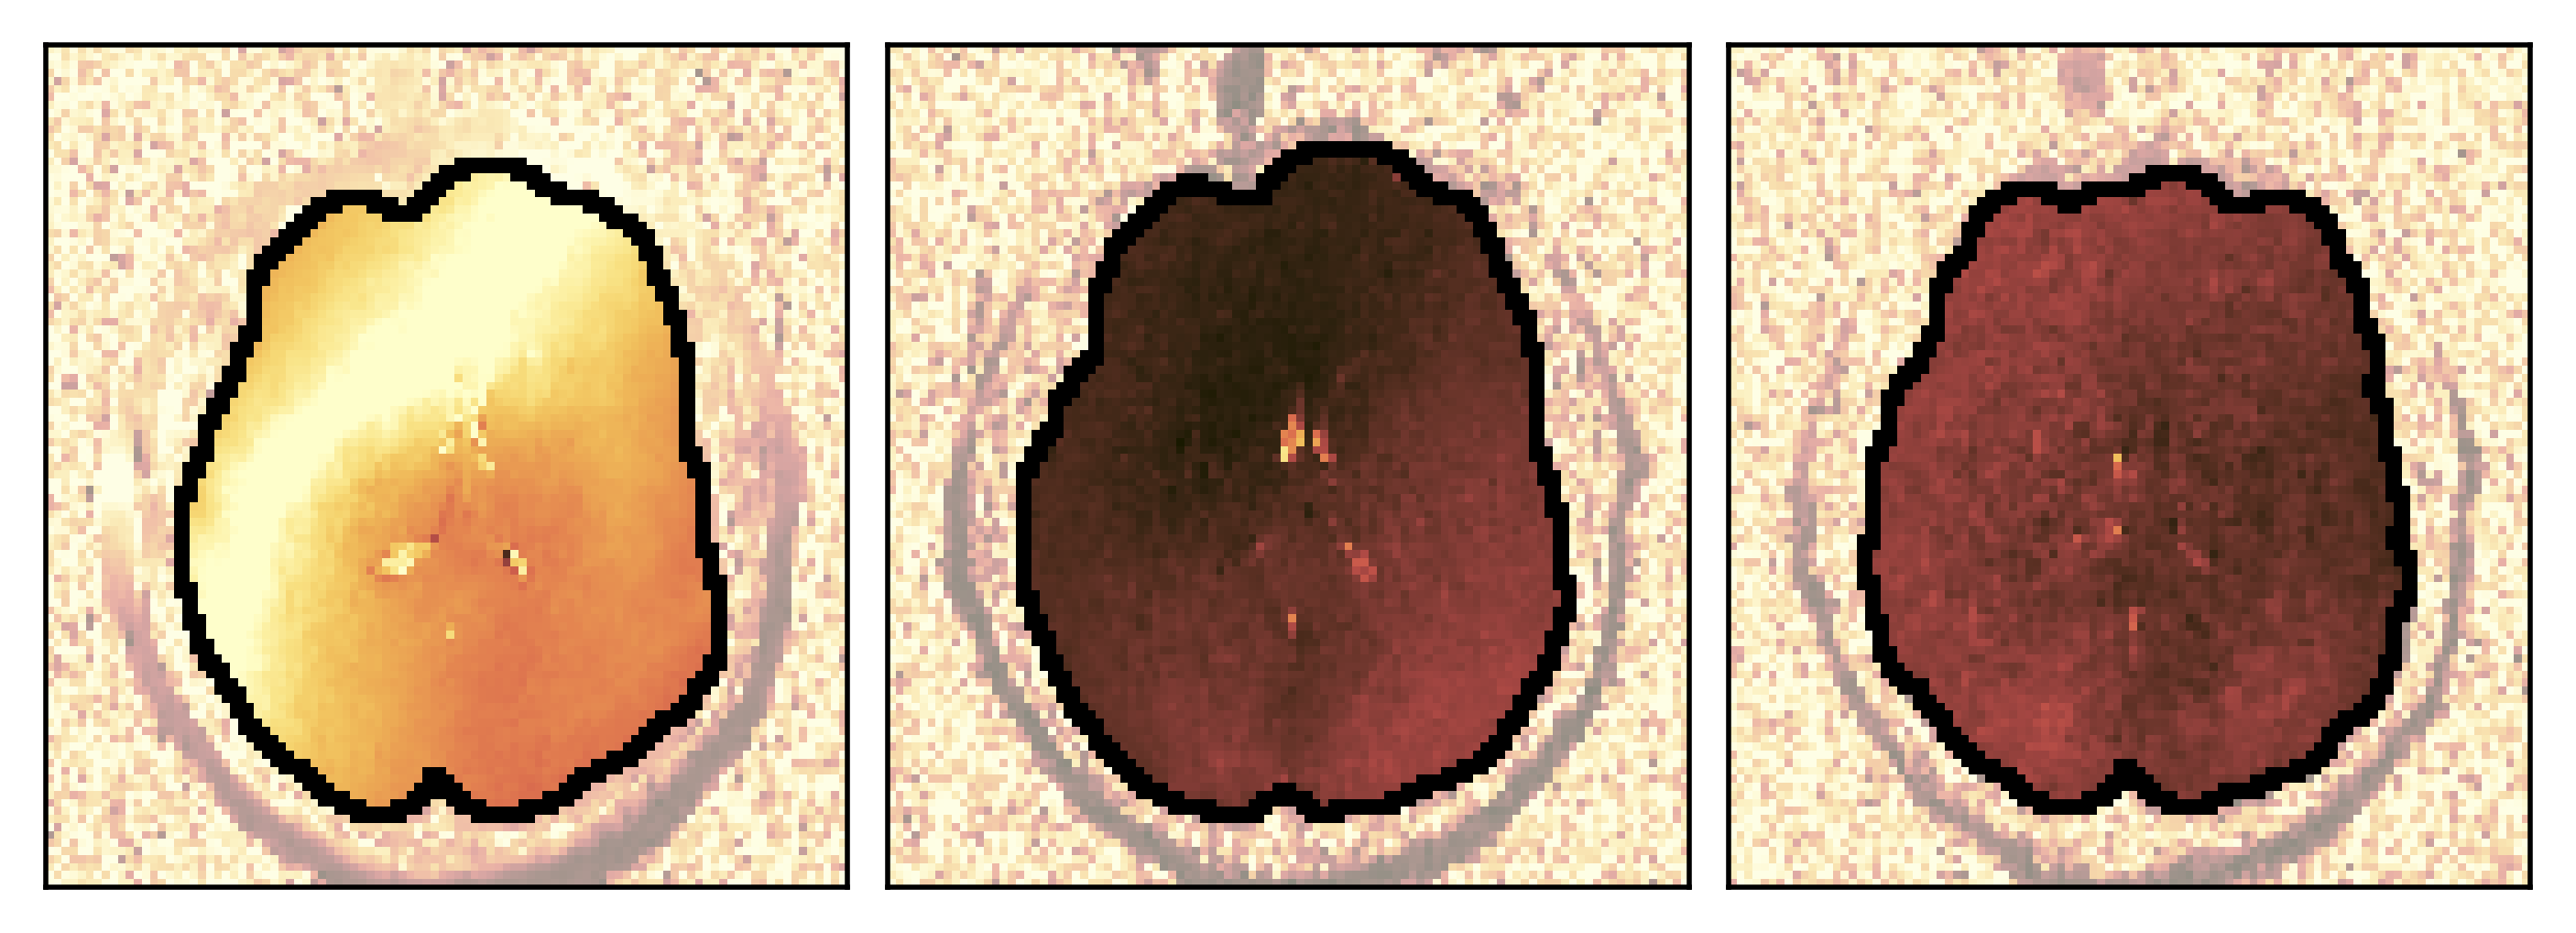

TD 2 Volunteer 0 slice 3
Median Temporal Phase SD M0 1.02 Median Temporal Phase SD M1 0.77 Median Temporal Phase SD M2 0.3 

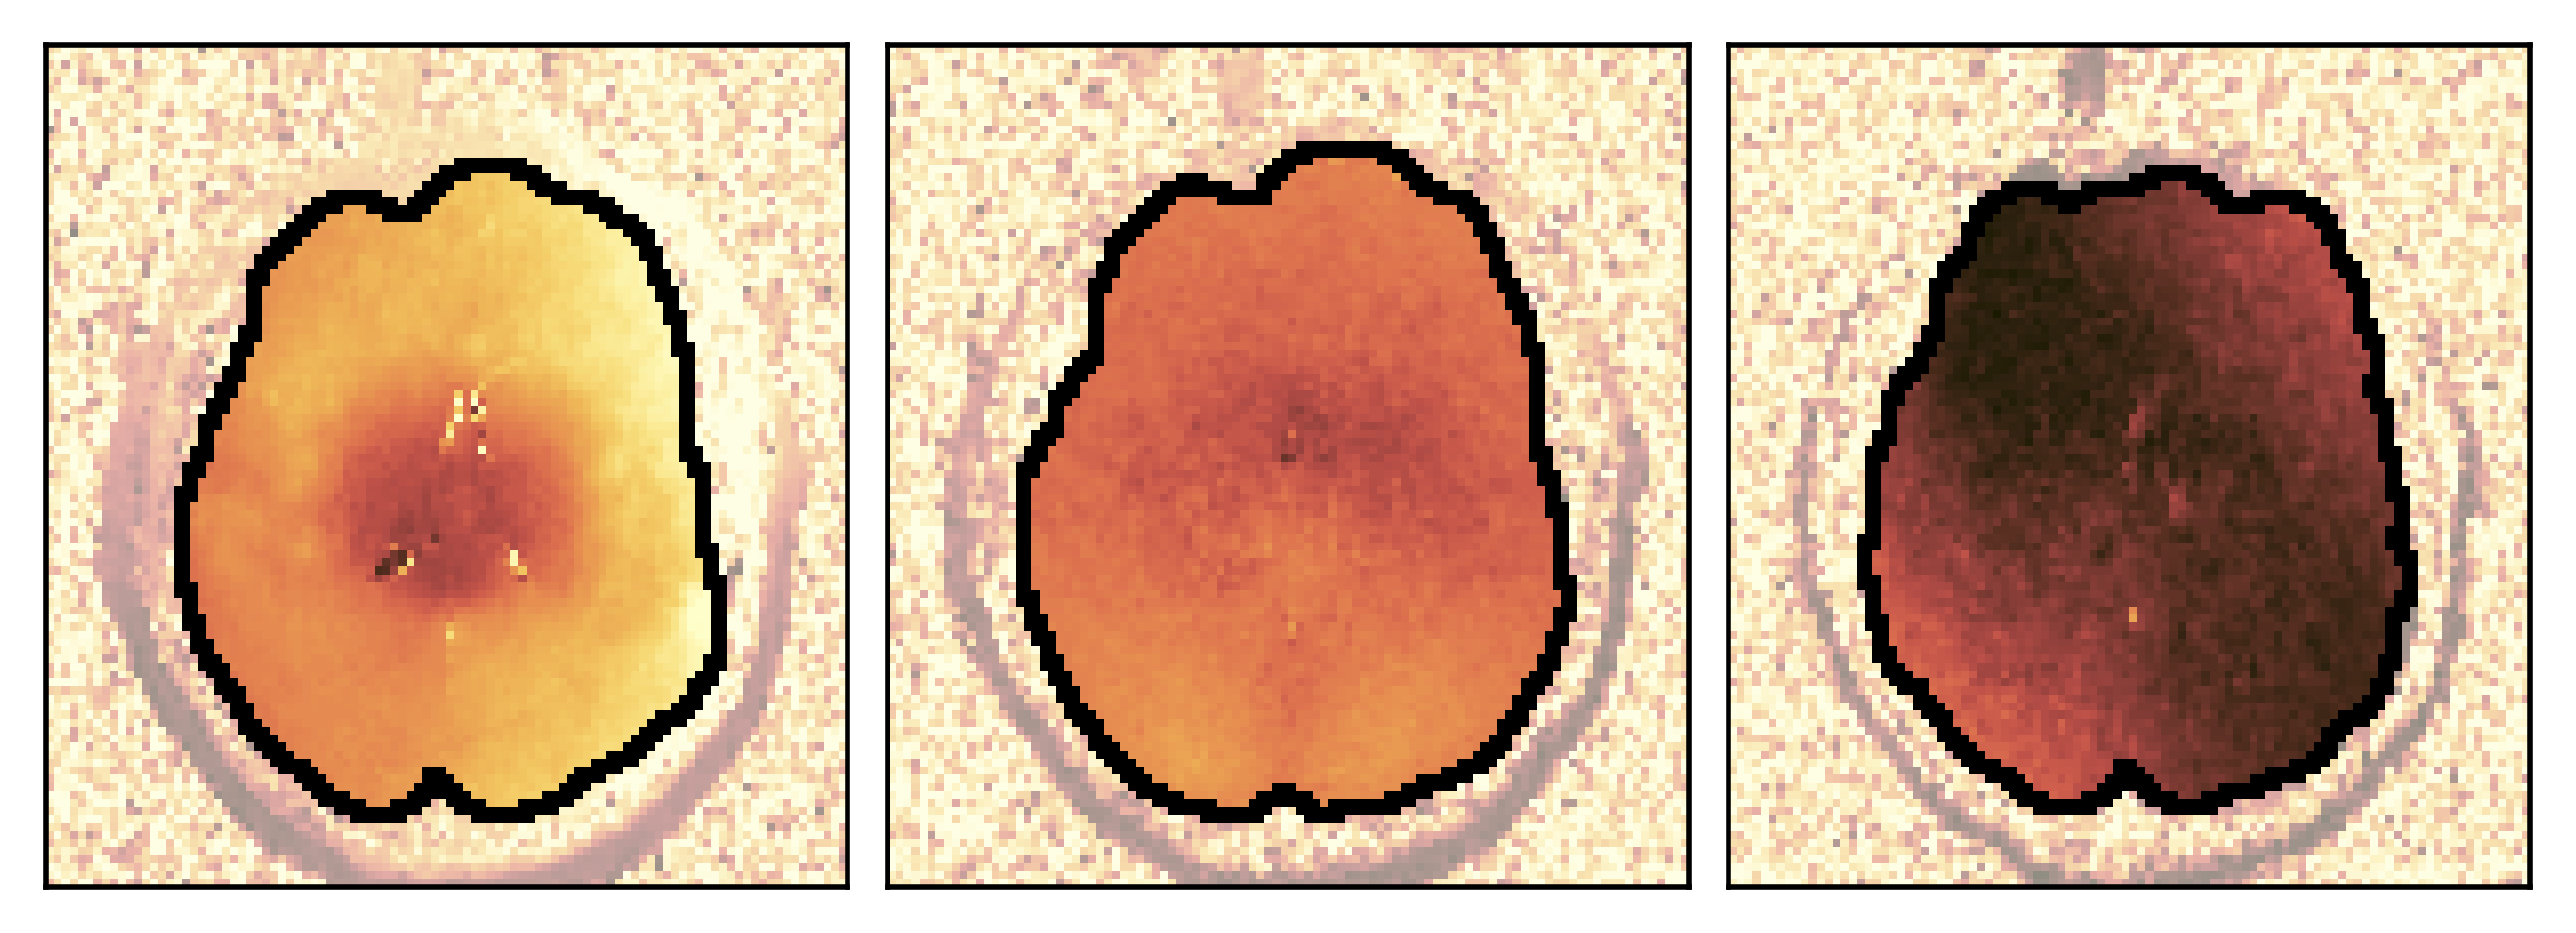

TD 3 Volunteer 0 slice 3
Median Temporal Phase SD M0 0.57 Median Temporal Phase SD M1 0.66 Median Temporal Phase SD M2 0.53 

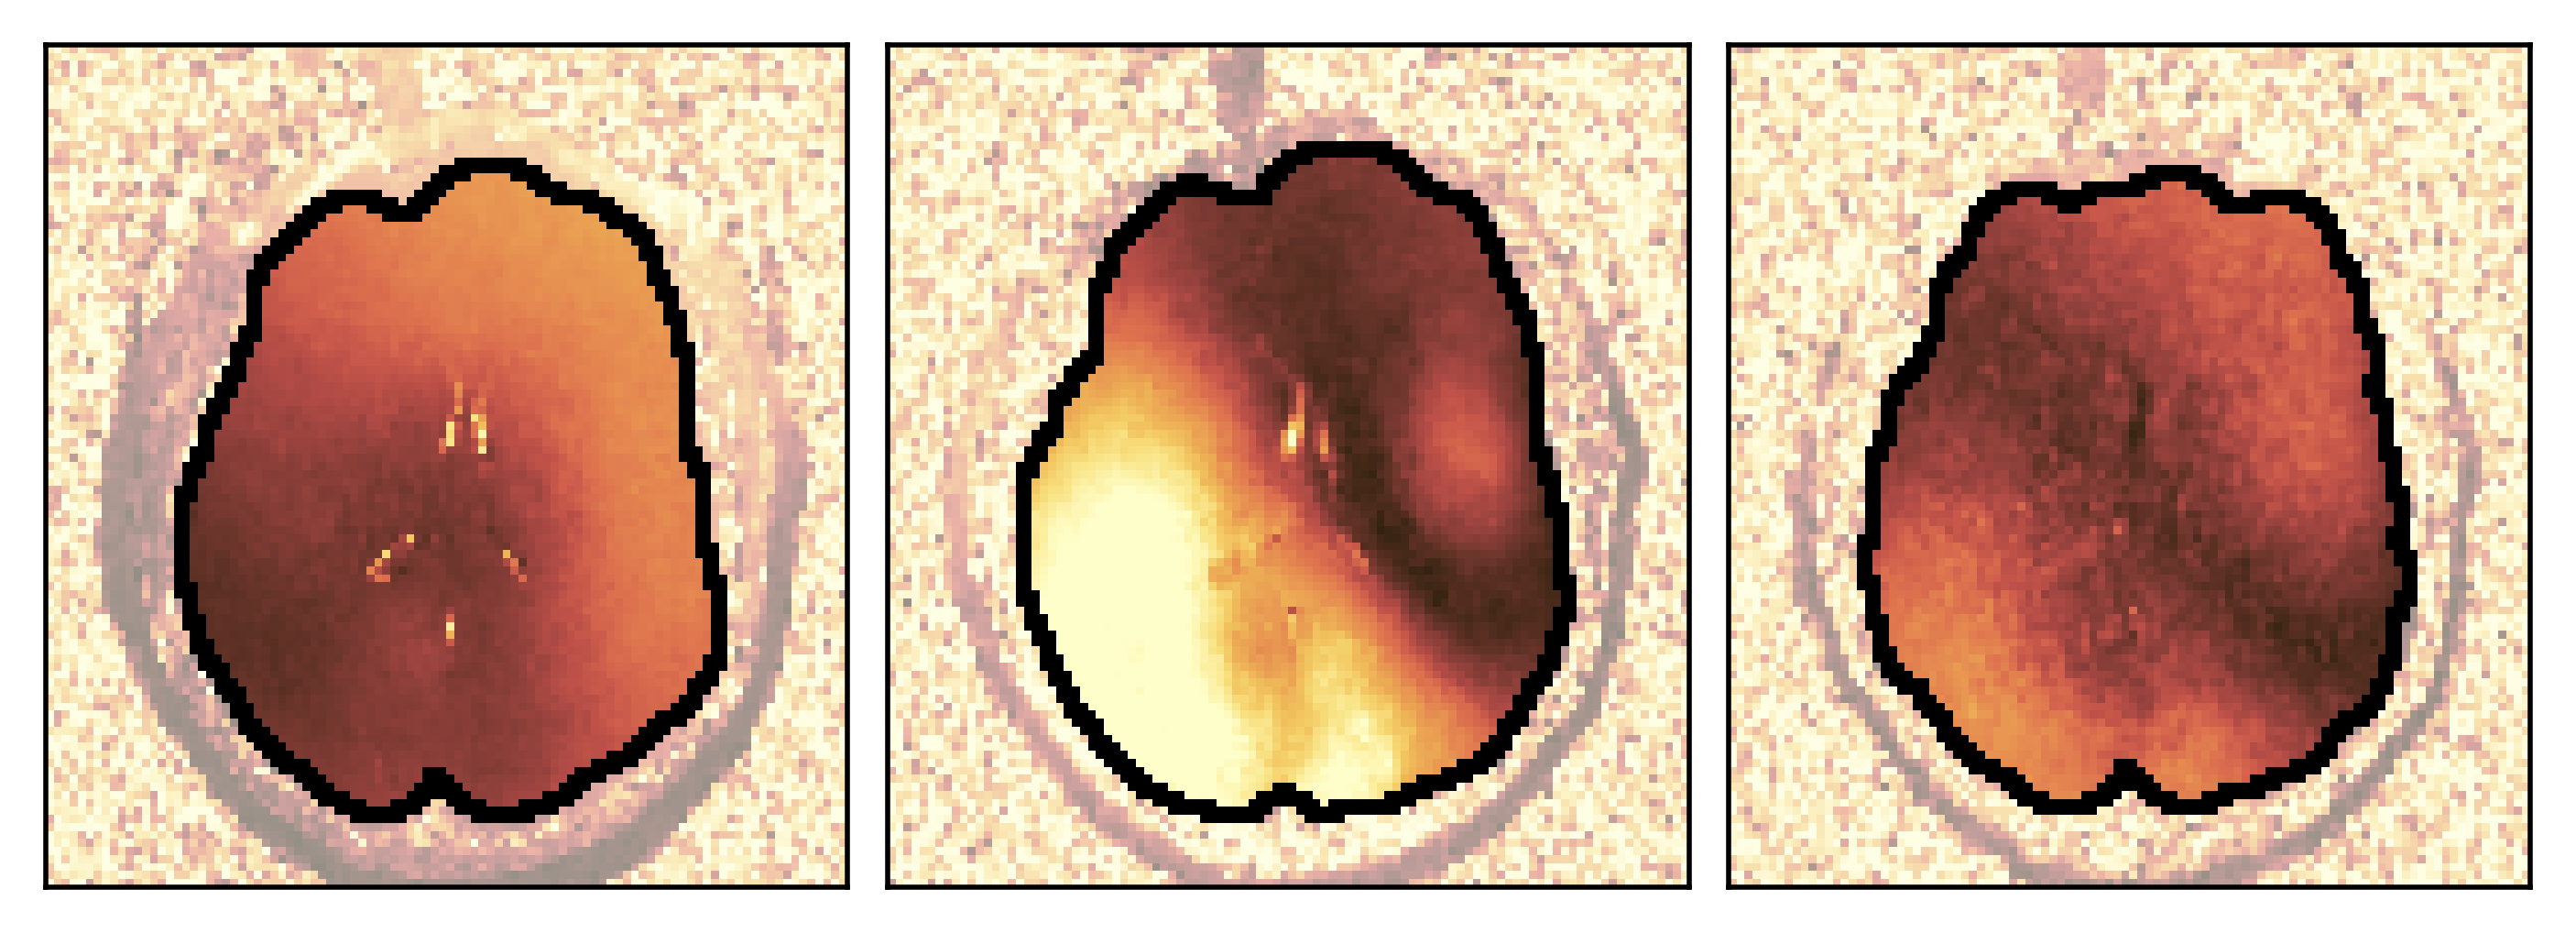

TD 4 Volunteer 0 slice 3
Median Temporal Phase SD M0 0.7 Median Temporal Phase SD M1 0.34 Median Temporal Phase SD M2 0.44 

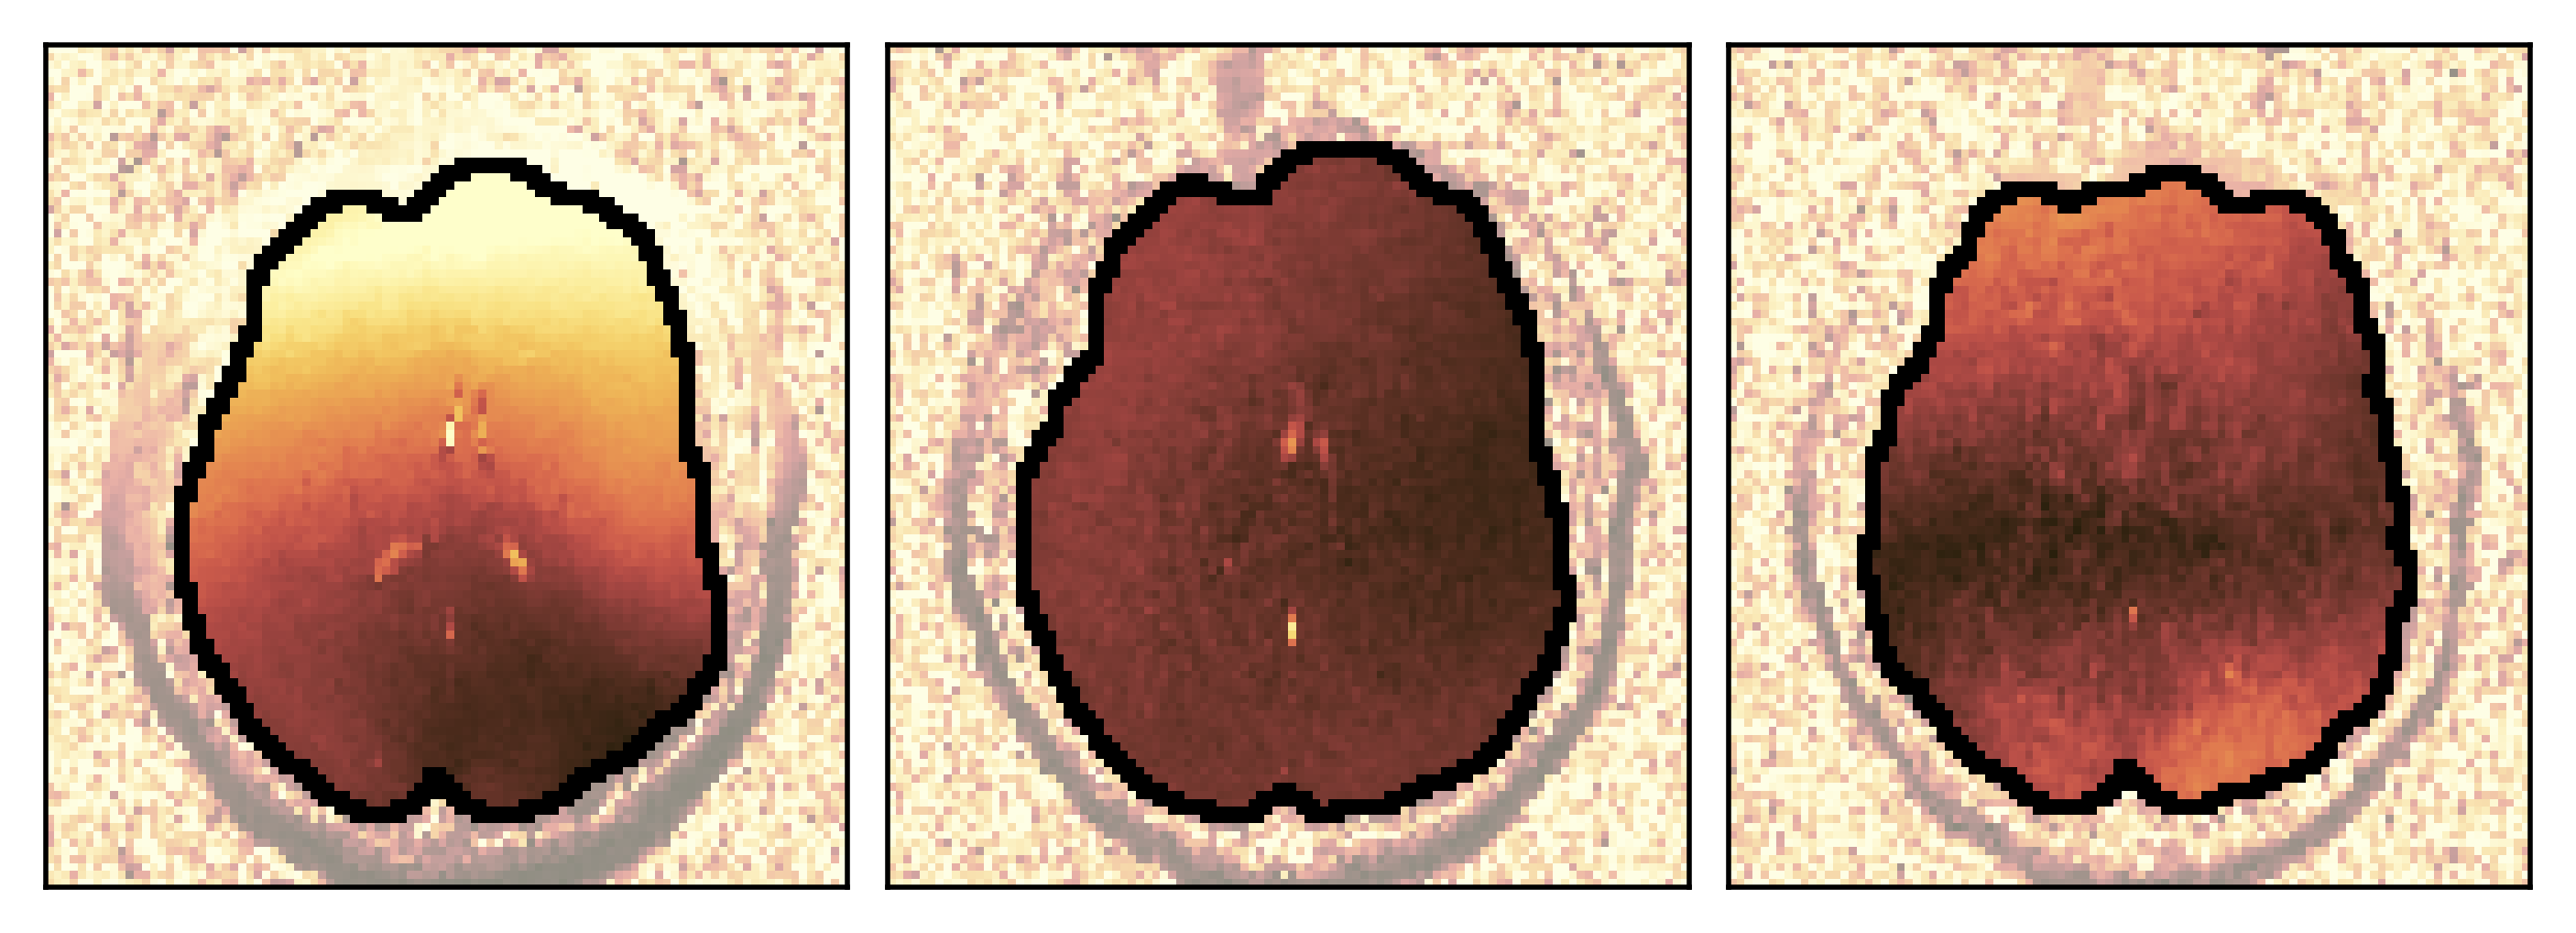

TD 5 Volunteer 0 slice 3
Median Temporal Phase SD M0 0.65 Median Temporal Phase SD M1 0.55 Median Temporal Phase SD M2 0.37 

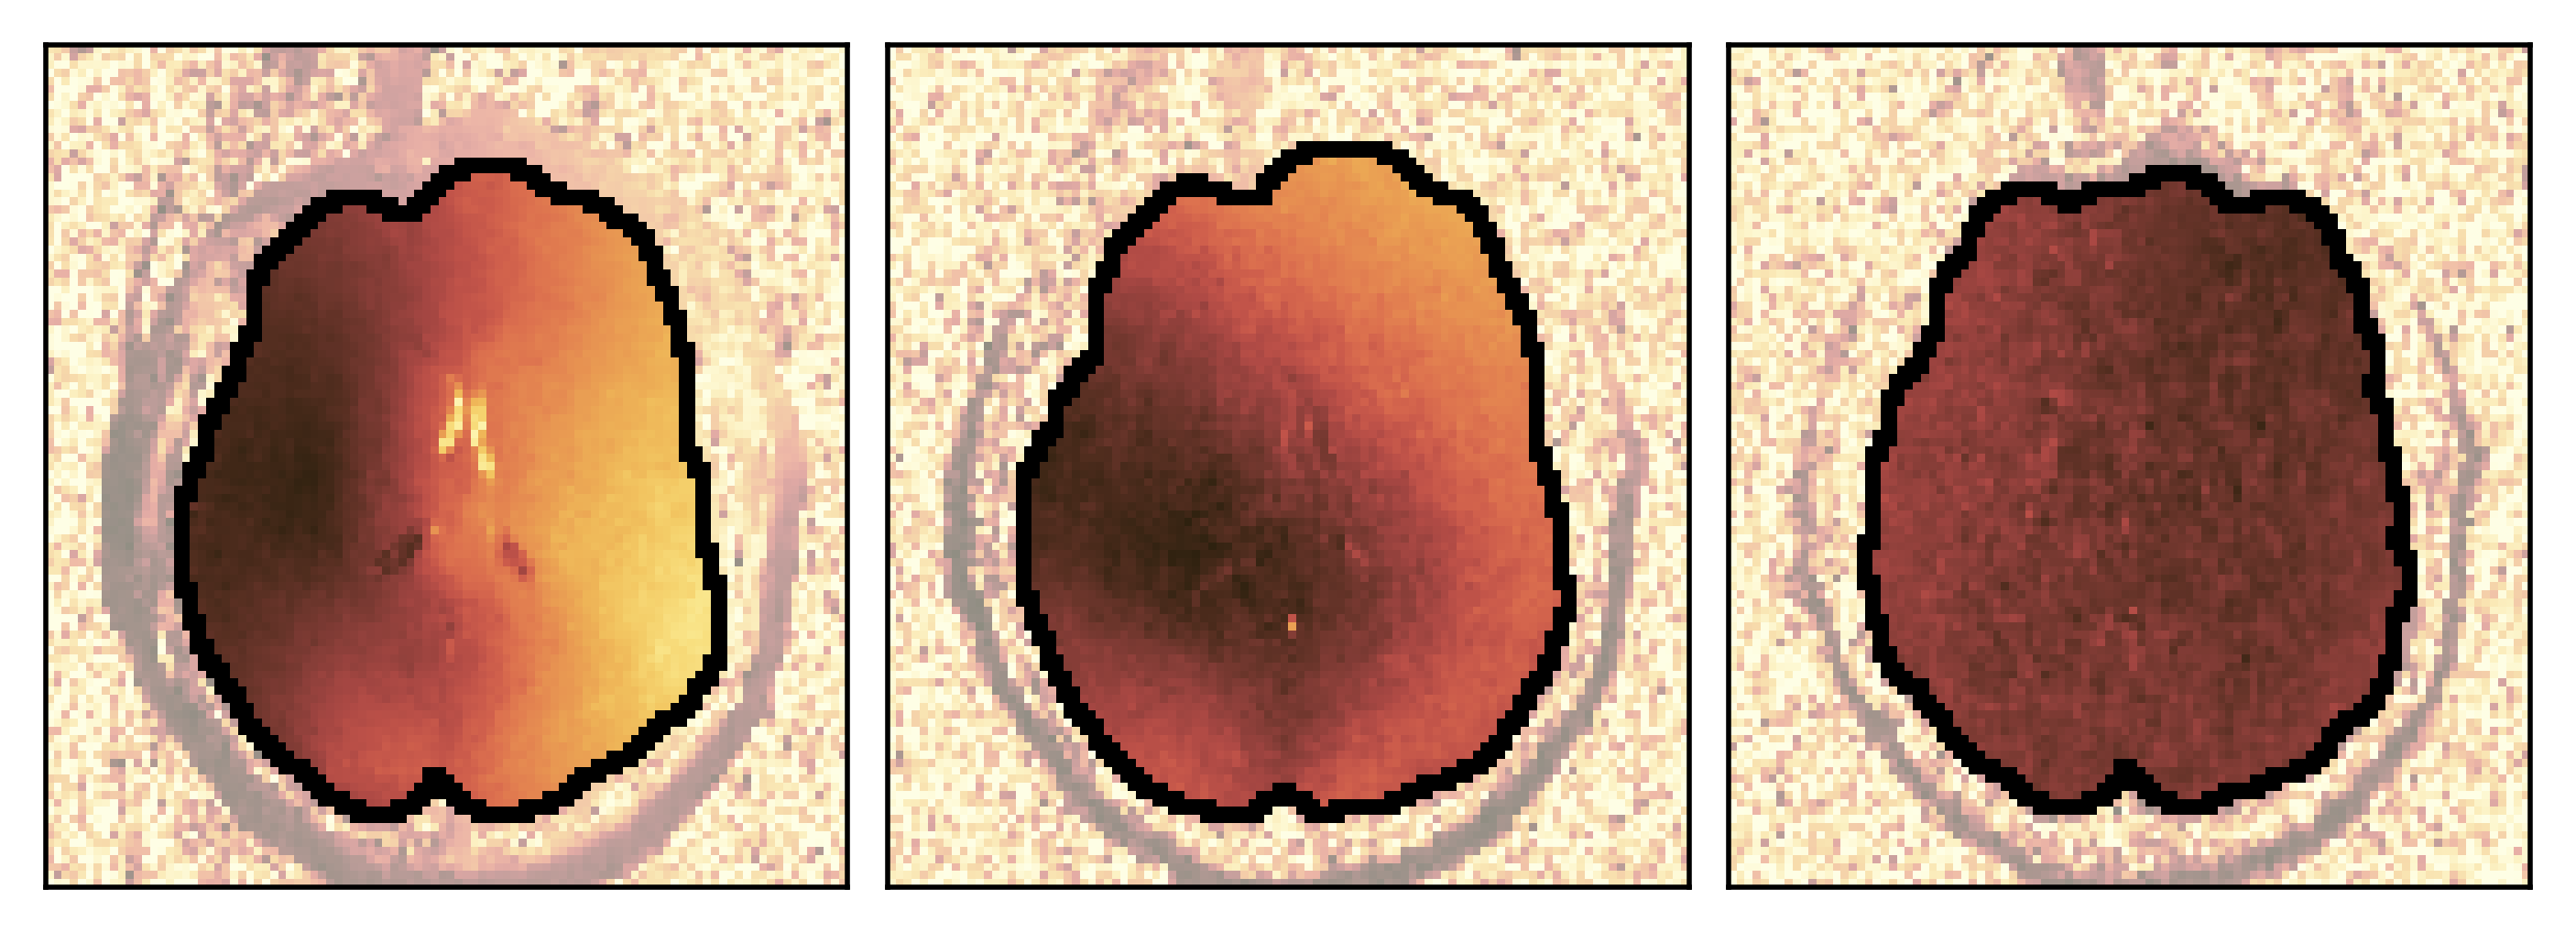

TD 6 Volunteer 0 slice 3
Median Temporal Phase SD M0 1.36 Median Temporal Phase SD M1 1.0 Median Temporal Phase SD M2 0.28 

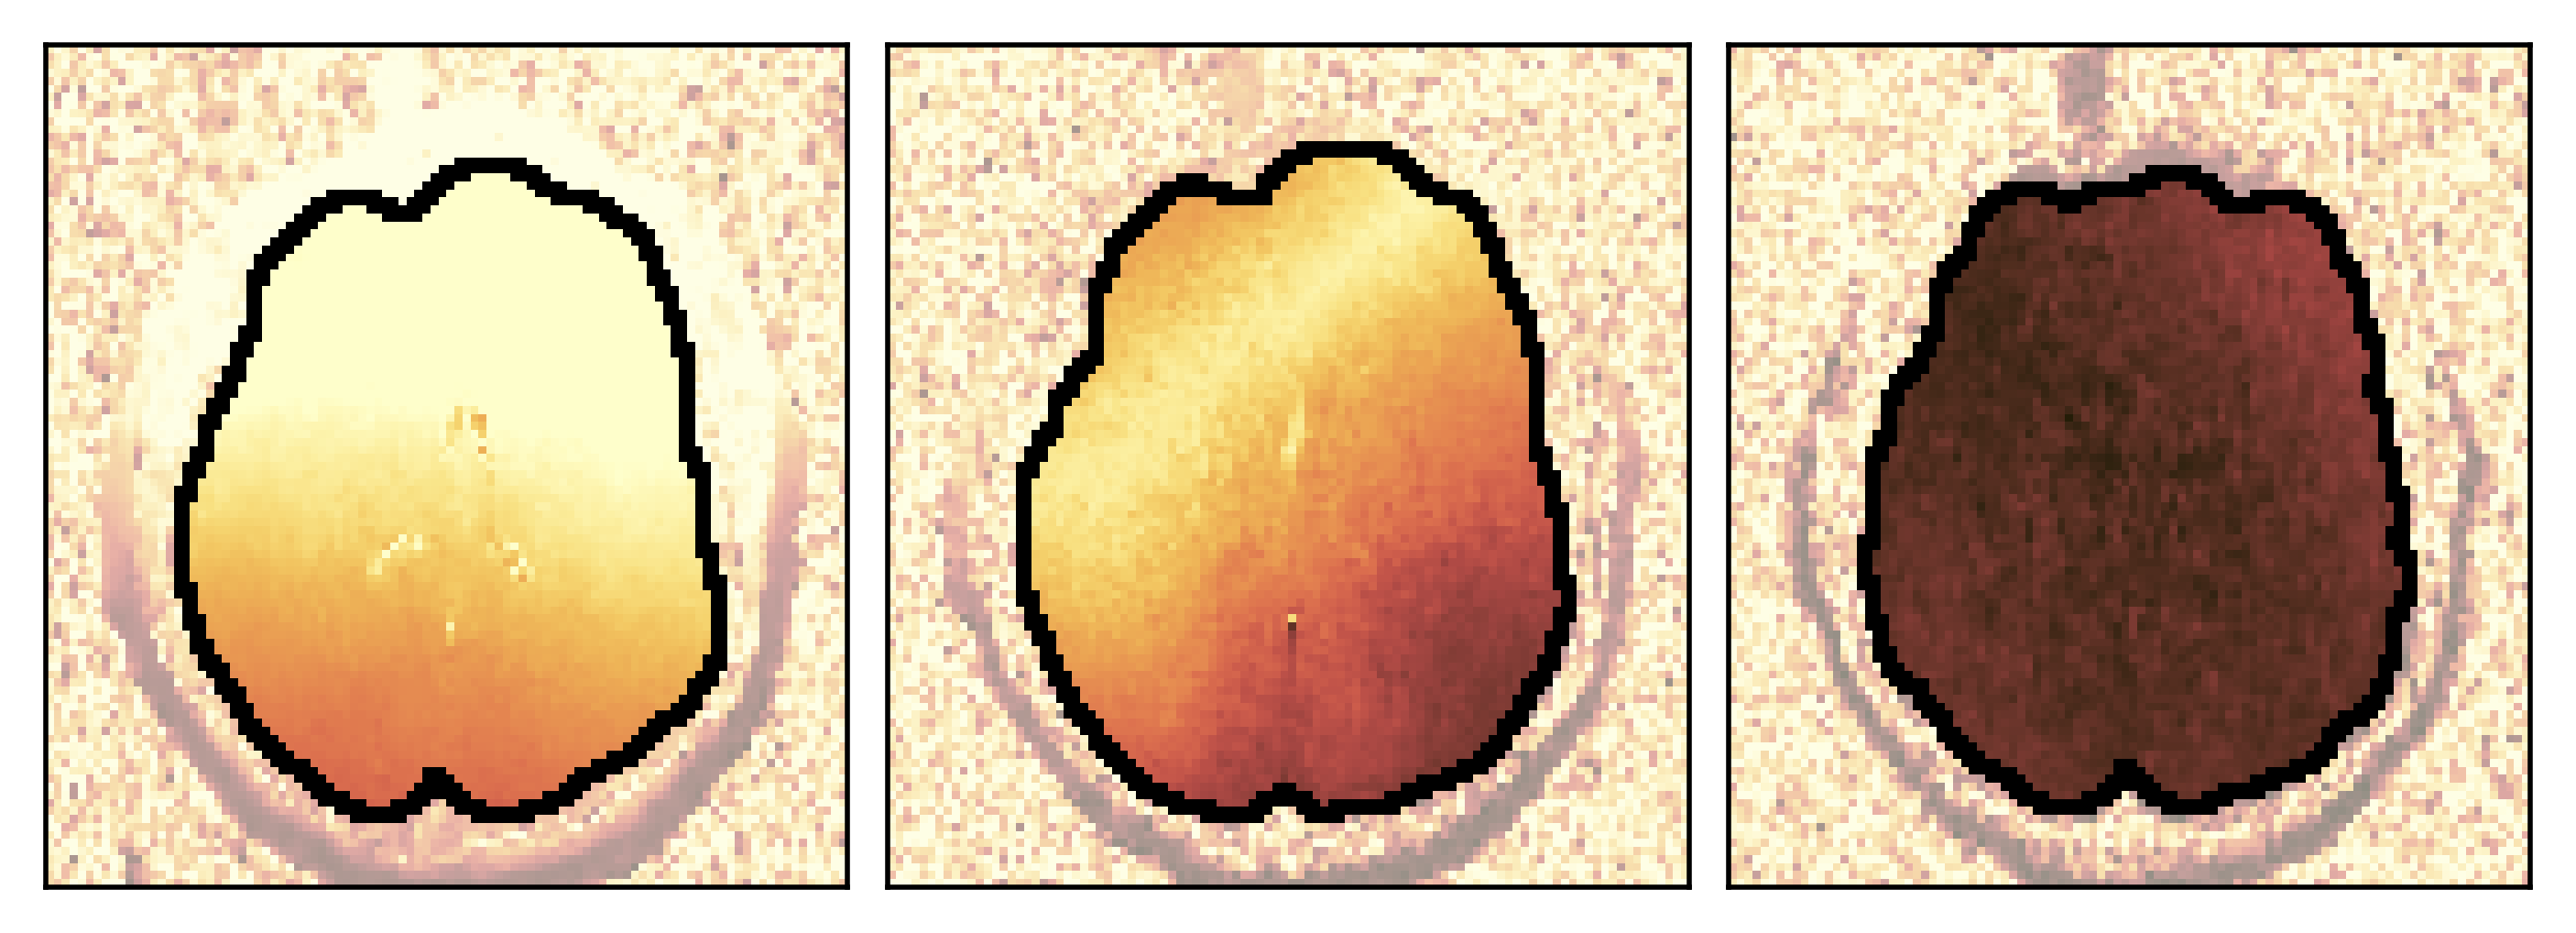

In [8]:
# Horizontal Fig plotting the standard deviation temporal phase maps 
for td in  range(7):#[1,4,7]:
    print('TD',td, 'Volunteer',vv,'slice',sl)
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(7,5), dpi=500)

    w1 = 15
    w2 = 120
    l1= 15
    l2 = 115

    color = cm.lajolla_r
    ######### STandard Deviation 
    phs_m0 = (M0_std) #* M0_mask[:,:,:,diffusion,0,:]
    phs_m1 = (M1_std) #* M1_mask[:,:,:,diffusion,0,:]
    phs_m2 = (M2_std) #* M2_mask[:,:,:,diffusion,0,:] 
    axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap =color,alpha = 0.5,interpolation = 'nearest')
    axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,td,],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')
    im2=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,td],vmin = 0,vmax = math.pi/2,cmap = color,alpha = 0.5,interpolation = 'nearest')

    phs_m0 = (M0_std[:,:,:,:,np.newaxis,:]) * M0_mask
    phs_m1 = (M1_std[:,:,:,:,np.newaxis,:]) * M1_mask
    phs_m2 = (M2_std[:,:,:,:,np.newaxis,:]) * M2_mask

    print('Median Temporal Phase SD M0',np.round(np.nanmedian(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td]),2),end = ' ')
    print('Median Temporal Phase SD M1',np.round(np.nanmedian(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td]),2),end = ' ')
    print('Median Temporal Phase SD M2',np.round(np.nanmedian(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td]),2),end = ' ')
    axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    im4=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion,0,td],vmin = 0,vmax = math.pi/2,cmap = color,interpolation = 'nearest')
    axes[0].imshow(get_edge(np.nan_to_num(M0_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[1].imshow(get_edge(np.nan_to_num(M1_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')
    axes[2].imshow(get_edge(np.nan_to_num(M2_mask[w1:w2,l1:l2,sl,diffusion,0,td])),vmin = 0,vmax = 1,cmap = 'gray_r',interpolation = 'nearest')


    for m in range(2):
        for j in range(3):
            axes[j].get_xaxis().set_ticks([])
            axes[j].get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.05, hspace=0.03)   
    plt.show()
    savename = 'TempPhs_vol_'+str(vv)+'slice_'+str(sl)+'TD_'+str(td) +'.svg'
    # Save the figure
    fig.savefig(savename, bbox_inches='tight' )
    

## Reference Magnitude Image 

Volunteer 0 sl 3


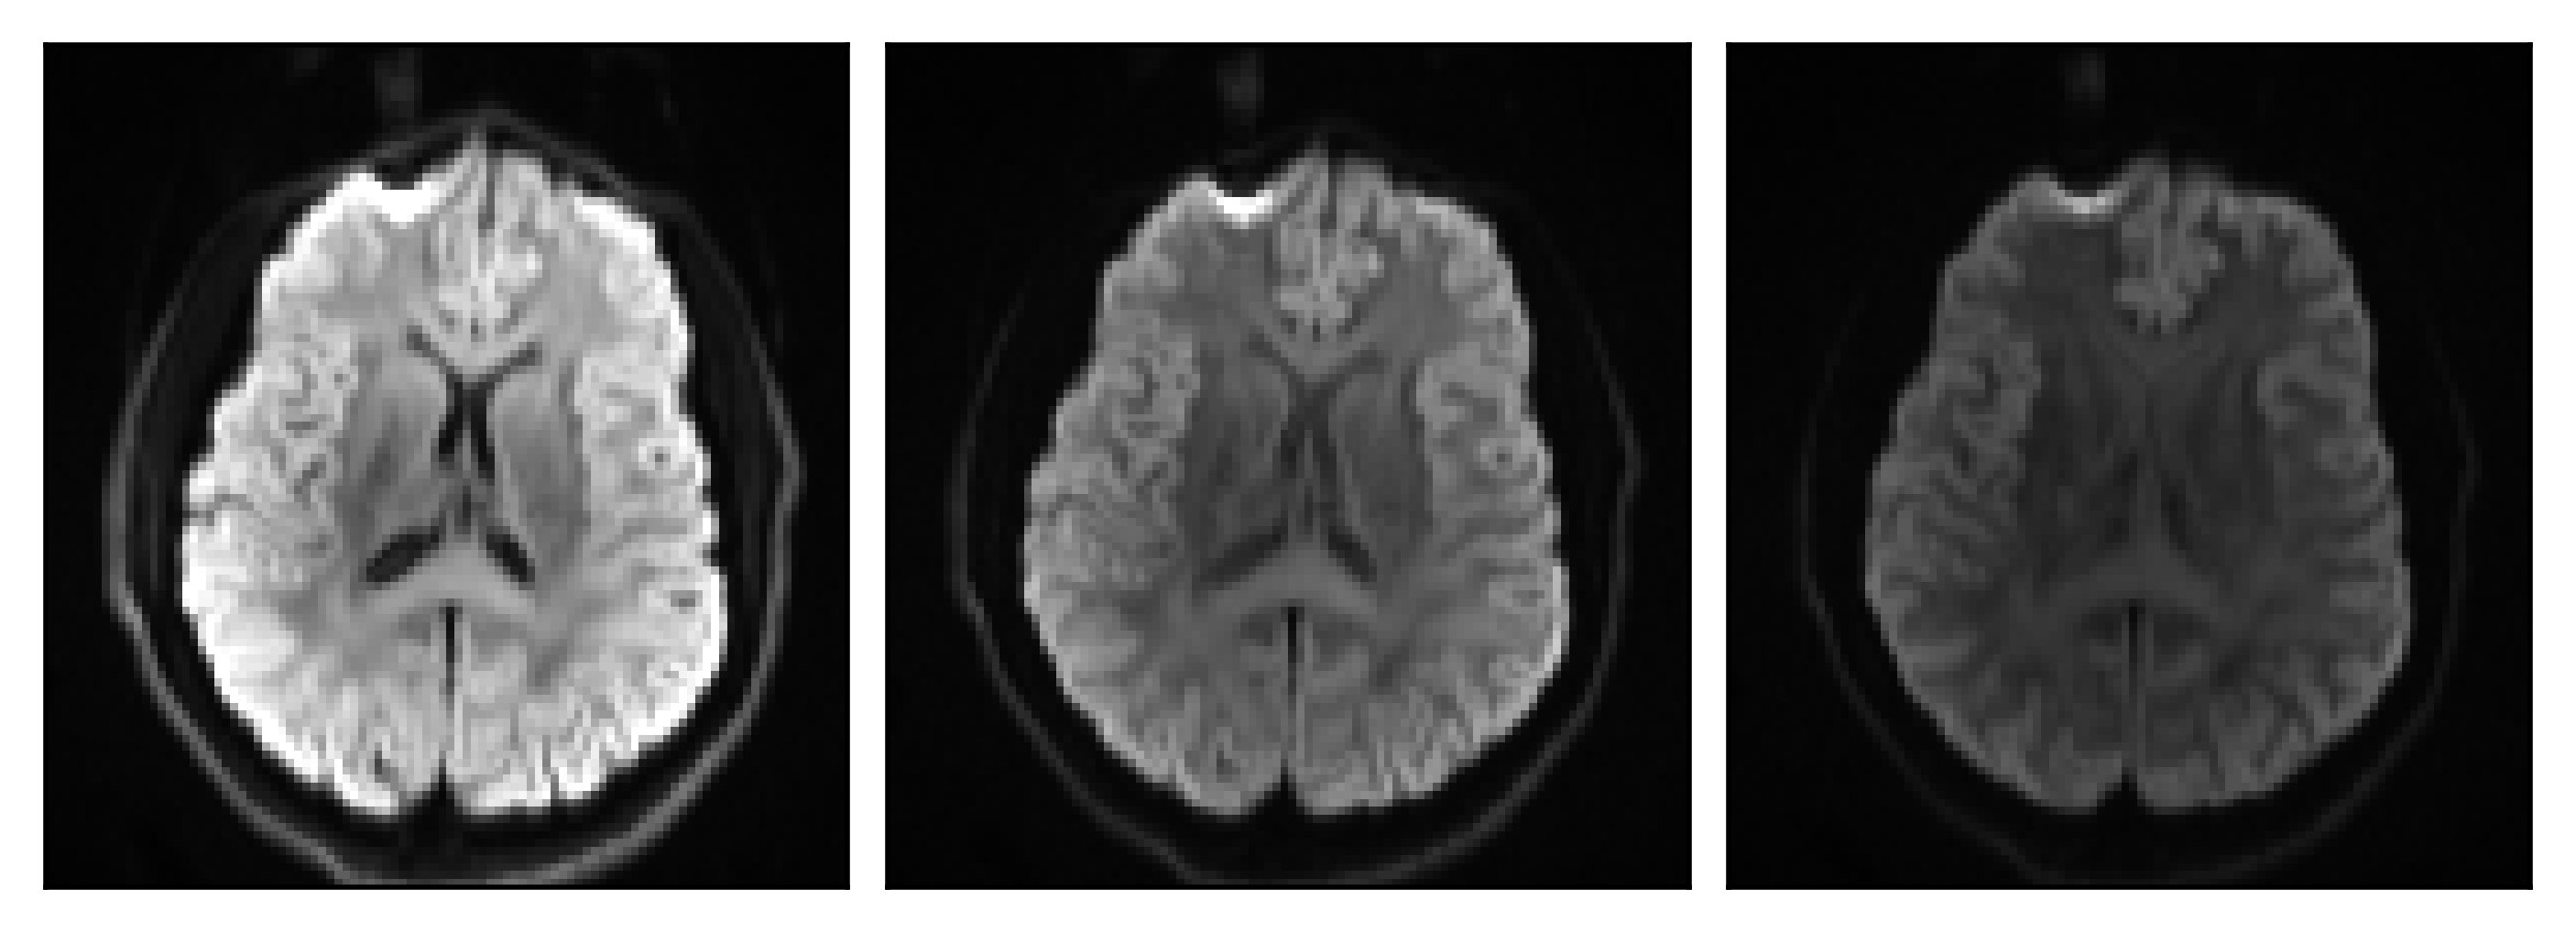

In [9]:
# Horizontal Fig plotting the standard deviation temporal phase maps 

print('Volunteer',vv,'sl',sl)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(7,5), dpi=500)

w1 = 15 #
w2 = 120
l1= 15
l2 = 115

color = 'gray'
######### magnitude
phs_m0 = np.nanmean(M0_mag,axis = (-2,-1))
phs_m1 = np.nanmean(M1_mag,axis = (-2,-1))
phs_m2 = np.nanmean(M2_mag,axis = (-2,-1))
axes[0].imshow(phs_m0[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = 400,cmap =color,interpolation = 'nearest')
axes[1].imshow(phs_m1[w1:w2,l1:l2,sl,diffusion,],vmin = 0,vmax = 400,cmap = color,interpolation = 'nearest')
im2=axes[2].imshow(phs_m2[w1:w2,l1:l2,sl,diffusion],vmin = 0,vmax = 400,cmap = color,interpolation = 'nearest')


for m in range(2):
    for j in range(3):
        axes[j].get_xaxis().set_ticks([])
        axes[j].get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.03)   
plt.show()
savename = 'Mag_vol_'+str(vv)+'slice_'+str(sl) +'.svg'
# Save the figure
fig.savefig(savename, bbox_inches='tight' )